# Forward Model - Minimum Working Example

This notebook shows an example of how the forward model works. Much of the preprocessing steps, such as interpolating the G-BASE samples to generate the input grid, is already done.

In [1]:
import ipywidgets as widgets
import netCDF4
import sys
import time
from numpy.lib.function_base import diff
import scipy as sp
import landlab
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FastscapeEroder, SinkFillerBarnes, FlowDirectorD8, ChannelProfiler, TrickleDownProfiler
from landlab.components.flow_accum.flow_accum_bw import find_drainage_area_and_discharge
from landlab import imshow_grid
from landlab.utils import get_watershed_mask,get_watershed_outlet,get_watershed_nodes
from landlab import imshow_grid

## Initialising Model space:
### Setting I/O:
The following cell sets the input and output parameters for the model. Provided with this notebook are the input grid for Mg.

In [2]:
element='Mg' #<<<<<<<<<<<<<<<<<<<<<<<< change to wanted element

interpolate_input = 'Data/' + element + '_gbase_log.nc' # path to interpolated G-BASE data
result_output_path = 'Forward_results/' + element + '_forward_result.asc' # path to full saved output
misfit_output_path = 'Forward_results/' + element + '_obs_v_pred.txt' # path to output at observed localities
path_obs_profile = 'Forward_results/' + element +'_obs_profile.txt' # path to output observations along main profile
path_pred_profile = 'Forward_results/' + element +'_pred_profile.txt' # path to output predictions along main profile

### Loading in Topography:
The next cell sets up the model grid and loads in the filled topography of the region. 

In [3]:
#loading in original DEM:
zr_nc=netCDF4.Dataset('Data/Topography_100m.nc')
zr_ma = zr_nc['z'][:,:]
mg = RasterModelGrid(zr_ma.shape,xy_spacing=(100,100)) #initialise raster model grid

#load in filled topography:
topography = np.load('Data/filled_topography.npy')

landmask_nc=netCDF4.Dataset('Data/landmask.nc')
landmask = landmask_nc['z'][:,:].data.astype(float)

zr = mg.add_field('node', 'topographic__elevation', topography) #add topography to model
dx = 100

flat_shape = zr.shape # a tuple to flatten arrays [number of nodes long]
full_shape = mg.shape # the full shape of the grid [rows, columns]

# Set up the boundary conditions on the square grid
mg.set_fixed_value_boundaries_at_grid_edges(True,True,True,True)

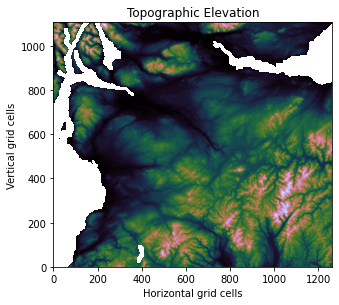

In [4]:
#Plotting filled topography
plt.figure(figsize = [5,5])
plt.title("Topographic Elevation")

plt.imshow(zr.reshape(full_shape)+landmask,cmap='cubehelix',origin='lower')
plt.xlabel('Horizontal grid cells')
plt.ylabel('Vertical grid cells')
plt.show()

### Generating Drainage Network:

The next cell initiates the D8 flow routing algorithm and adds the river system to the raster model grid. In this study, a river system is defined as any stream with a drainage network $> 8km^2$

In [5]:
# instantiate the flow routing:

frr = FlowAccumulator(
    mg,
    'topographic__elevation',
    flow_director = 'FlowDirectorD8')
frr.run_one_step()  # flow routing

zrold = zr[mg.nodes] # pre-incision elevations

a, q_homo_incis = find_drainage_area_and_discharge(mg.at_node['flow__upstream_node_order'], mg.at_node['flow__receiver_node']) # a is number of nodes
# q is cumulative flux for homogeneous incision

area = mg.at_node['drainage_area']
np.amax(area)
area_threshold = 8 #float(sys.argv[1]) #25 km2
is_drainage = area > (area_threshold*1000000) #km2 to m2
mg.add_field('node','channels',is_drainage,clobber=True)

array([False, False, False, ..., False, False, False], dtype=bool)

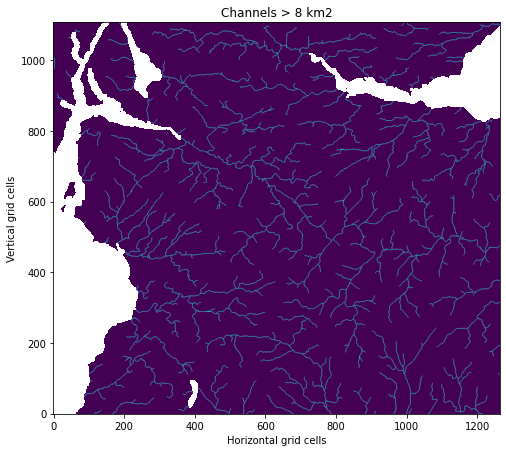

In [6]:
#Plotting drainage network:
plt.figure(figsize=[8,8])
plt.imshow(is_drainage.reshape(full_shape)+landmask,origin='lower') 
plt.xlabel('Horizontal grid cells')
plt.ylabel('Vertical grid cells')

plt.title("Channels > 8 km2")
plt.show()


### Loading in input data:
The next cell loads in the interpolated G-BASE grid and adds it to the model grid. As the concentrations in the grid are given in $log_{10}$, they need to be transformed out of log-space before running the model.

In [7]:
comp_nc=netCDF4.Dataset(interpolate_input) #loading in the interpolated grid

#adding the input data to the model grid
comp_ma = comp_nc['z'][:,:]
comp_log = mg.add_zeros('node','log_bdrck')
comp_log += np.reshape((comp_ma.data.astype(float)),comp_log.shape)

#converting from log10 to absolute values and adding those to the grid as well
comp = mg.add_zeros('node','bdrck')
comp += np.reshape(((10**comp_ma).data.astype(float)),comp.shape) 

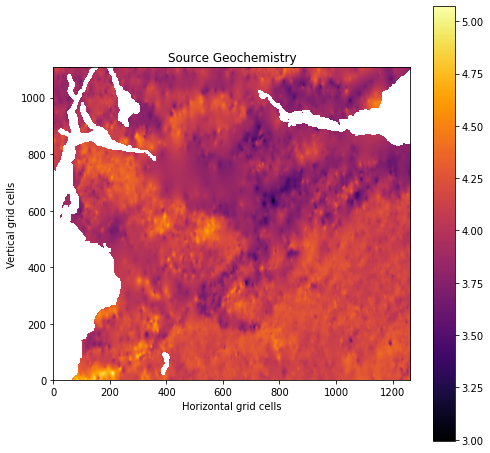

In [8]:
# Plotting upstream source geochemistry:
plt.figure(figsize = [8,8])
plt.title("Source Geochemistry")

plt.imshow(comp_log.reshape(full_shape)+landmask,cmap='inferno',origin='lower')
plt.colorbar()
plt.xlabel('Horizontal grid cells')
plt.ylabel('Vertical grid cells')
plt.show()

## Running forward model:
With everything loaded in, the forward model can be run. 

First, the total sediment flux across the grid needs to be found. This is done using the LandLab function `find_drainage_area_and_discharge`. In this study, a homogenous erosion model is used.

Second, the absolute flux for a given element needs to be found. For this the function `find_drainage_area_and_discharge` is run. The upstream source geochemistry is used as the runoff rate at each cell.

Finally, the absolute flux is normalised by total sediment flux to find the downstream river sediment concentrations.

In [9]:
#Find total sediment flux first, assuming homogenous incision:
a, q = find_drainage_area_and_discharge(mg.at_node['flow__upstream_node_order'], mg.at_node['flow__receiver_node']) # a is number of nodes

#Run forward model using composition and homogenous erosion
a, sed_comp = find_drainage_area_and_discharge(mg.at_node['flow__upstream_node_order'], mg.at_node['flow__receiver_node'],runoff = comp)
sed_norm = sed_comp/q #normalise composition by total sediment flux
sed_norm[q==0] = comp[q==0] #setting composition to bedrock composition where sed flux is 0

#visualise by turning back to log10 and running through channel system:
sed_comp_norm_channel = np.log10(sed_norm) * is_drainage

#Add model results to raster model grid:
mg.add_field('node','homo_incis_sed',sed_norm,clobber=True)
mg.add_field('node','homo_incis_log_sed',np.log10(sed_norm),clobber=True)
mg.add_field('node','homo_incis_log_sed_channel',sed_comp_norm_channel,clobber=True)


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

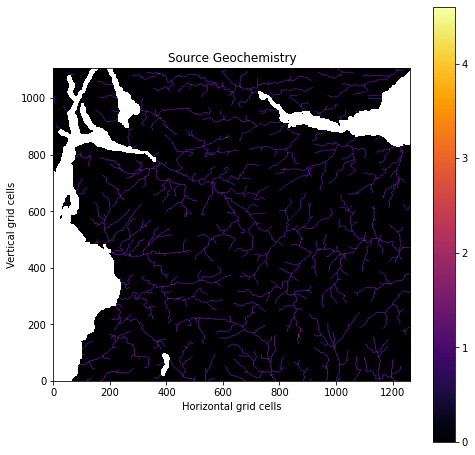

In [10]:
# Plotting upstream source geochemistry:
plt.figure(figsize = [8,8])
plt.title("Source Geochemistry")

plt.imshow(sed_comp_norm_channel.reshape(full_shape)+landmask, cmap='inferno',origin='lower')
plt.colorbar()
plt.xlabel('Horizontal grid cells')
plt.ylabel('Vertical grid cells')
plt.show()

At this point the raw model result is finished and can be used for further analysis with little processing needed. The next cell saves the model output. 

**Note** If the file already exists, this will fail. The cell can be skipped without hindering the rest of the notebook.

In [11]:
#save model result:
mg.save(result_output_path, names=['homo_incis_log_sed_channel']) # NOTE: if the file already exists, this will fail. Comment or remove file

## Post-Processing
The rest of this notebooks shows parts of the post-processing and analysis used to generate the result breakdown as found in Appendix A.

### Loading in observations
To compare the model predictions to independent observations the samples must be loaded in and added to the Model Grid. To ensure that the samples lie on the river network, they are snapped to the closest cell that is part of the river system. Some localities needed manual corrections, which are shown below.

**Note:** For simplicity, this notebook uses the same locality data as the inverse model. This differs slightly to the data presented in the report, where 6 anomalous samples are used in addition to the samples here.

In [12]:
# loading in sample localities in following format [x, y, sample #]:
sample_data = np.loadtxt('Data/filtered_sample_loc.dat',dtype=str) 
sample_locs = sample_data[:,0:2].astype(float)

# initiating array of channel locations and nudging array:

channel_xy = np.flip(np.transpose(np.where(is_drainage.reshape(mg.shape))),axis=1)*100 # xy coordinates of channels
nudge = np.zeros(sample_locs.shape) # initiate nudging array

#nudging samples that are otherwise snapping to the wrong cell:

nudge[17] = [0,-200]    #nudging loc 632137 to S
nudge[34] = [-700,0]    #nudging loc 632164 to W
nudge[38] = [0,-400]    #nudging loc  632170 to S
nudge[39] = [-100,0]    #nudging loc 632171 to W
nudge[56] = [0,100]     #nudging loc 632197 to N
nudge[16] = [-300,-100] #nudging loc 632136 to SW
nudge[4 ] = [-300,-100] #nudging loc 632109 to SW
nudge[50] = [0,-100]    #nudging loc 632189 to S
nudge[3 ] = [-200,-100] #nudging loc 632108 to SW
nudge[64] = [0,100]     #nudging loc 700012 to N
nudge[69] = [100, -100] #nudging loc 700022 to SE


nudged_locs = sample_locs + nudge # Apply the nudges

# Fit the data to the nearest channel node:

fitted_locs = np.zeros(sample_locs.shape) # Initialise snapped locality array
for i in np.arange(nudged_locs.shape[0]):
    sample = nudged_locs[i,:]
    diffs = channel_xy-sample
    distances = np.linalg.norm(diffs,axis=1)
    shortest = np.amin(distances)
    fitted_locs[i,:] = channel_xy[np.where(distances==shortest)]
    
    
# Adding unique ID to each sample locality:

loc_indxs = np.transpose(np.flip((fitted_locs/100).astype(int),axis=1))
loc_nodes = np.ravel_multi_index(loc_indxs,dims=full_shape)

# Following statements should be 0 and 'True' if all localities are correctly snapped on the model grid:
print(np.sum(fitted_locs%100))
print((is_drainage[loc_nodes]).all())

locality_num_grid = np.zeros(flat_shape) - 20
locality_num_grid[loc_nodes] = sample_data[:,2].astype(float).astype(int)

mg.add_field('node','loc_nums',locality_num_grid,clobber=True) # Adding locality number to grid field

0.0
True


array([-20., -20., -20., ..., -20., -20., -20.])

Text(0.5, 1.0, 'Manual check of localities (you have to zoom in!)')

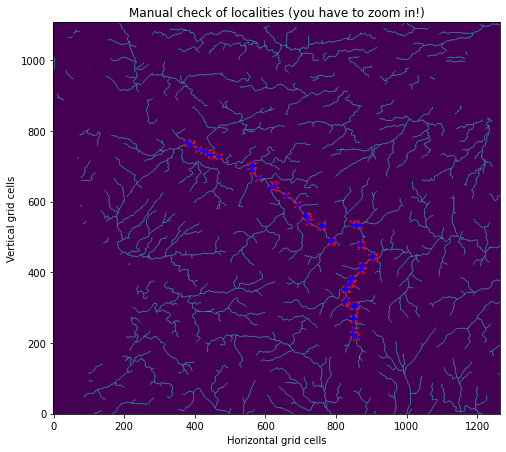

In [13]:
#Plotting resulting sample locations:
plt.figure(figsize=[8,8])
plt.imshow(is_drainage.reshape(full_shape),origin='lower') 
plt.scatter(x=sample_locs[:,0]/mg.dx, y=sample_locs[:,1]/mg.dx, marker="x",c='r', s=40)
plt.scatter(x=fitted_locs[:,0]/mg.dx, y=fitted_locs[:,1]/mg.dx, marker="+",c='b', s=40)
#plt.scatter(x=sample_locs[64,0]/mg.dx, y=sample_locs[64,1]/mg.dx, marker='.', c='k', s=40) #plotting point fursthest down stream
plt.scatter
plt.xlabel('Horizontal grid cells')
plt.ylabel('Vertical grid cells')
plt.title("Manual check of localities (you have to zoom in!)")

In the next cell, the geochemical data is loaded in and converted into $log_{10}$ space.

In [14]:
obs_data = pd.read_csv('Data/converted_chem_data.csv') #read in geochem data
elems =  obs_data.columns[1:].tolist() # List of element strings
obs_data[elems]=obs_data[elems].astype(float) # Cast numeric data to float
obs_log = np.log10(obs_data[element])

### Generating Misfit
The next cell extracts the predicted concentrations at the sample localities and the difference between the predictions and observations is calculated. To create a usable file for further analysis, the `out_array` combines all relevant data in one multi-dimensional array. The result is then saved.

`out_array`: [sample #],[x_coordinate],[y_coordinate],[observations],[predictions],[observation-prediction]

In [15]:
pred_log = sed_comp_norm_channel[loc_nodes]
diff_array = obs_log-pred_log
out_array = np.array([sample_data[:,2].astype(int), sample_data[:,0].astype(float), sample_data[:,1].astype(float), pred_log, obs_log, diff_array]).T

#saving out_array:
np.savetxt(misfit_output_path, out_array, fmt = ['%d', '%.18f', '%.18f','%.5f', '%.5f', '%.5f'], header='SAMPLE_No X_COORD Y_COORD CONC_PREDICTION CONC_OBSERVATION MISFIT')

### Generating River Profile
The final post-processing needed is to extract the predicted downstream source geochemistry along the main channel of the Clyde river. This is done via LandLabs in-built `ChannelProfiler` functionality. The final output is an array for the prediction profile `pred_profile_output` and a file for the observations along the same profile `obs_profile_output`.

`pred_profile_output`: [distance along profile],[predicted concentrations] ; $\approx 1$ point every 100 m to generate continuous line

`obs_profile_output`: [distance along profile of sample],[observed concentrations]

The next cell finds the mouth of the Clyde and initialises the Channel profile to find the longest profile in the model.

In [16]:
#create river profile:
node_eg = mg.grid_coords_to_node_id(377,769) #random node inside catchment
outlet = get_watershed_outlet(mg,node_eg) #finding sink node of Clyde

profiler = ChannelProfiler(mg,main_channel_only=True,outlet_nodes=[outlet]) # Initiates the long profiler 
profiler.run_one_step() # Extract longest profile in each channel

# Extract node IDs and stream distances
prof_id = list(profiler.data_structure[outlet].values())[0]["ids"] # The IDs of the nodes in the profile.
prof_distances = list(profiler.data_structure[outlet].values())[0]["distances"] # Distances upstream from outlet 
prof_xy = np.unravel_index(prof_id, full_shape) # Convert stream nodes into xy coordinates

This cell extracts the predictions and observations along the main profile. Finally this is saved for future analysis and visualisation.

In [17]:
# Extract downstream predictions along long profile
prof_geochem = sed_norm[prof_id] # Extract geochemistry at each node
# Extract observations along profile
prof_obs = obs_log[np.isin(loc_nodes,prof_id)]
prof_misfit = diff_array[np.isin(loc_nodes,prof_id)]
prof_loc_nodes = loc_nodes[np.isin(loc_nodes,prof_id)] # sample locs on profile
obs_prof_x = np.zeros(prof_obs.size) # Extract stream distance for each locality
for i in np.arange(obs_prof_x.size): # loop sets distance for each locality
    obs_prof_x[i]= prof_distances[prof_id==prof_loc_nodes[i]]
    
#saving all profile distances and chemistry
obs_profile_output = np.array([obs_prof_x,prof_obs]).T
pred_profile_output = np.array([prof_distances,np.log10(prof_geochem)]).T #converting geochem into log10
np.savetxt(path_obs_profile, obs_profile_output)
np.savetxt(path_pred_profile, pred_profile_output)

# Visualisation
Finally, the results are visualised similar to how they are presented in Appendix A.

### Cross Plot between observations and predictions


Text(0.5, 1.0, 'Cross Plot of observations vs. predictions')

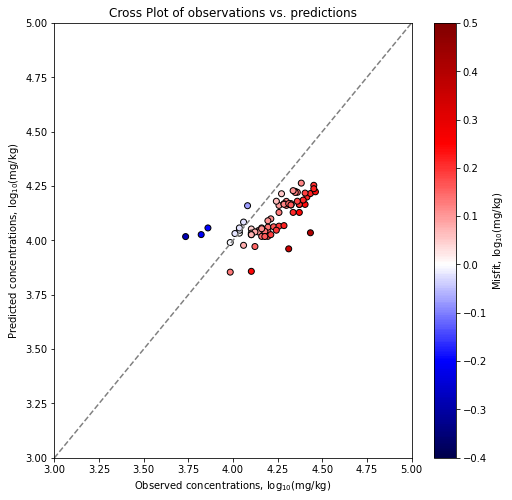

In [18]:
diag = [-1,0,1,2,3,4,5,6] # generating array for 1:1 line

#generating misfit colour:
divnorm=colors.TwoSlopeNorm(vmin=-0.4, vcenter=0., vmax=0.5)

plt.figure(figsize=[8,8])
plt.scatter(obs_log, pred_log, c = diff_array, cmap='seismic', edgecolors='k', norm=divnorm)
plt.plot(diag,diag, '--', color='grey')
plt.colorbar(label='Misfit, log$_{10}$(mg/kg)')
plt.xlim(3,5)
plt.ylim(3,5)
plt.xlabel('Observed concentrations, log$_{10}$(mg/kg)')
plt.ylabel('Predicted concentrations, log$_{10}$(mg/kg)')
plt.title('Cross Plot of observations vs. predictions')

### Profile along main channel of Clyde river

Text(0.5, 1.0, 'Concentrations along profile of main channel')

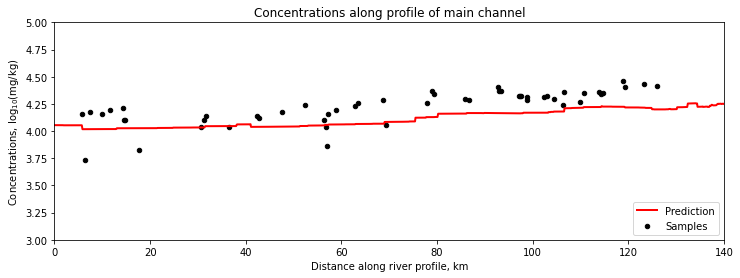

In [19]:
plt.figure(figsize=[12,4])
plt.plot(pred_profile_output[:,0]/1000,pred_profile_output[:,1], c='r', lw = 2, label = 'Prediction')
plt.scatter(obs_profile_output[:,0]/1000,obs_profile_output[:,1], c='k', s = 20, label = 'Samples')
plt.legend(loc='lower right')
plt.xlim(0,140)
plt.ylim(3,5)
plt.xlabel('Distance along river profile, km')
plt.ylabel('Concentrations, log$_{10}$(mg/kg)')
plt.title('Concentrations along profile of main channel')